<h1><center>Employee Promotion Prediction</center></h1>
<h3><center>Predicting whether an employee is promoted or not based on various factors</center></h3>

The aim is to analyze the various factors that can contribute to the promotion of an employee. Based on the analysis, predict which employees will be promoted.<br>

The following details for an employee is given in the dataset :-
    
   * Department - department of the employee
   * Region - region as designated by the company
   * Education - qualification of the employee
   * Gender - gender of the employee
   * Recruitment channel - means via which employee was recruited
   * No of trainings - total number of trainings undergone by the employee
   * Age - age of the employee
   * Previous year ratings - previous year performance ratings of the employee
   * Length of service - total years worked for the company
   * KPIs met(1 if >80%) - total KPIs met in the tenure
   * Average training score - average score on trainings
   * Awards won - Awards won if any
   
The target column is the *is_promoted* column. The column is binary and specifies whether the employee was promoted or not.

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,cross_validate,validation_curve
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv("hr problem data - train.csv")
df.head(5)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
1,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
2,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0
3,58896,Analytics,region_2,Bachelor's,m,sourcing,2,31,3.0,7,0,0,85,0
4,49017,Sales & Marketing,region_7,Bachelor's,f,sourcing,1,35,5.0,3,1,0,50,1


Right off the bat, some column names have to be changed for ease of access. The following colum names have been changed :-

* KPIs_met >80% - KPIs_met
* awards_won? - awards_won


In [3]:
cols = ['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met', 'awards_won',
       'avg_training_score', 'is_promoted']
df.columns = cols

In [4]:
df.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met,awards_won,avg_training_score,is_promoted
count,44492.000000,44492.000000,44492.000000,41125.000000,44492.000000,44492.000000,44492.000000,44492.000000,44492.000000
mean,39180.934348,1.250000,34.794345,3.334055,5.865751,0.352176,0.023442,63.369797,0.085206
std,22599.924968,0.605472,7.658301,1.261816,4.275574,0.477654,0.151306,13.360335,0.279192
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19643.500000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39173.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58744.250000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78297.000000,10.000000,60.000000,5.000000,34.000000,1.000000,1.000000,99.000000,1.000000


In [5]:
df.isnull().sum()

employee_id                0
department                 0
region                     0
education               1958
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    3367
length_of_service          0
KPIs_met                   0
awards_won                 0
avg_training_score         0
is_promoted                0
dtype: int64

The `describe()` method gives a general view of all the numerical columns in the dataset.<br>
The `isnull().sum()` chaining counts the number of Null values per column.<br>
Only the *education* and *previous_year_rating* columns have Null values in them. The *previous_year_rating* column gives the rating employee recieves each year on the Likert scale (here 1 to 5). A new employee joining in the current year would not have a previous year rating, to prove this assumption, the previous year rating which are Null are compared to the *length_of_service* column which gives the number of years employee has now worked for the company. The length of service has the minimum value of 1, this implies that any new joinee is also by default said to have worked for the company for one year.

In [6]:
df.previous_year_rating.value_counts(dropna=False)

3.0    15018
5.0     9610
4.0     8029
1.0     5043
2.0     3425
NaN     3367
Name: previous_year_rating, dtype: int64

In [7]:
service_filter = df[df.length_of_service == 1]
print(
    "Null rating counts of employees with length of service 1\n",
    service_filter.previous_year_rating.isnull().sum()
)
print(
    "Null rating counts of employees with length of service 1 and promoted\n",
    service_filter[service_filter.is_promoted == 1].previous_year_rating.isnull().sum()
)
df.previous_year_rating = df.previous_year_rating.fillna(0)

Null rating counts of employees with length of service 1
 3367
Null rating counts of employees with length of service 1 and promoted
 271


The 3367 Null values were all new employees. From these, 271 employees have actually recieved a promotion. This reason makes a compelling arguement not to remove these rows. Thus the *previous_year_ratings* are filled with 0s instead, making it the lowest score as well as indicating absence of value (rating) all together.<br>

It is odd that the *education* column has so many Null values. Qualifications mean a great deal and hence it is imperative the Null values are analyzed. Out of the total 1856 missing rows, 102 of those employees have recieved a promotion, thus the Null values have to be imputed.

In [8]:
df[df.education.isna()].is_promoted.value_counts()

0    1856
1     102
Name: is_promoted, dtype: int64

One solution to impute the *education* column is to fill the Null values with the mode of the column. The mode of the column gives the qualification that is most frequent among the employees. The mode is a good option since during hiring process, the company looks into the employee's qualifications and hence recruits them. It can be assumed that every department has a different criterion for qualification, for example An engineer hired would mostly be a *Bachelor's* whereas an employee working in management would mostly be a *Master's*.<br>
Analyzing the *Department* column based on the above argument, there are 9 unique departments in the company. 

In [9]:
depts = df.department.unique()

for dept in depts:
    edu = df[df.department == dept].education.mode()[0]
    print(dept," : ",edu)
    

Sales & Marketing  :  Bachelor's
Technology  :  Bachelor's
Analytics  :  Bachelor's
R&D  :  Bachelor's
Procurement  :  Bachelor's
HR  :  Bachelor's
Operations  :  Bachelor's
Finance  :  Bachelor's
Legal  :  Bachelor's


The above arguments are not in line with the data. Hence simply filling the education with *Bachelor's* would suffice for the analysis.

In [10]:
df.education = df.education.fillna(df.education.mode()[0])

Viewing the number of unique values in each column gives a good idea as to which columns are categorical and which are continuous.

In [11]:
df.nunique()

employee_id             44492
department                  9
region                     34
education                   3
gender                      2
recruitment_channel         3
no_of_trainings            10
age                        41
previous_year_rating        6
length_of_service          34
KPIs_met                    2
awards_won                  2
avg_training_score         61
is_promoted                 2
dtype: int64

The dataset seems clean with all the Null values removed. The aim of the project is to analyze which factors contribute to an employee's promotion. Over the next few markdowns, a detailed analysis has been done for each column that seems relevant.<br>

Firstly looking into two columns *awards_won* and *KPIs_met*. These columns directly describe the performance of the employee. KPIs are Key Performance Indicators that evaluate their success at reaching targets. In this case, any employee with > 80% success rate at reaching the target has a value of 1 otherwise a value of 0. Similarly, *awards_won* is 1 if the employee has won an award from the company.

C:\Users\Manoj\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Manoj\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


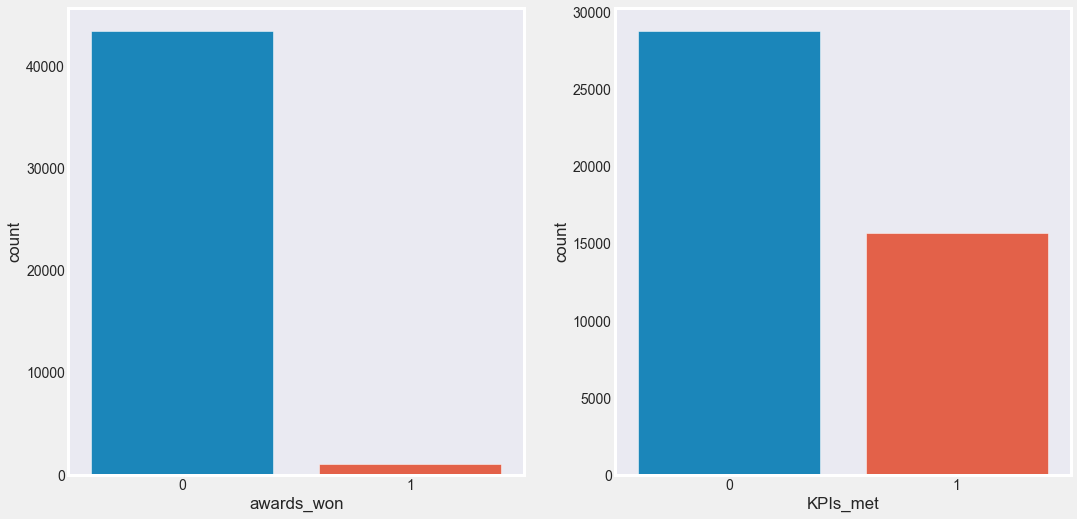

In [12]:
plt.style.use('fivethirtyeight')
plt.subplots(figsize=(16,8))
sns.set_style('dark')
plt.subplot(1,2,1)
sns.countplot(df['awards_won'])
plt.subplot(1,2,2)
sns.countplot(df['KPIs_met'])
plt.show()

A very small set of employees have actually won awards. Whereas a good percentage of people have greater than 80% success rate on reaching targets (KPIs). A closer look into the employees having both won and award and achieved targets or either of the two.

C:\Users\Manoj\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Manoj\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Manoj\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_promoted', ylabel='count'>

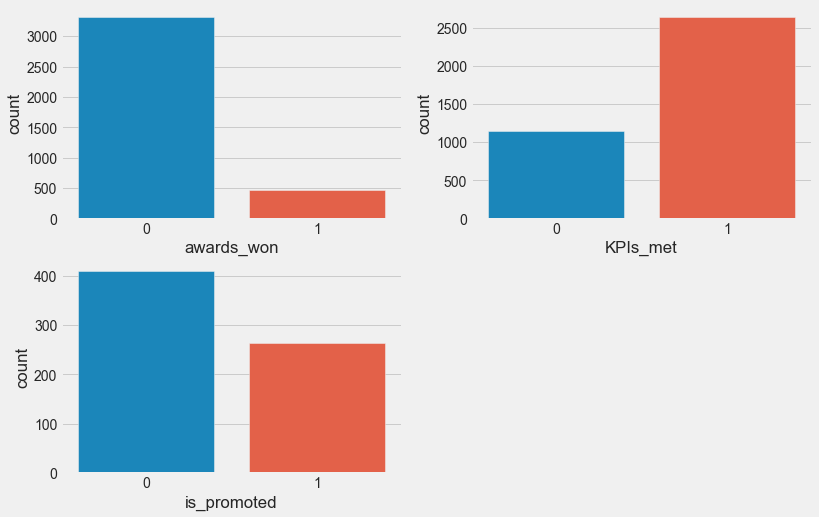

In [13]:
star_emps = df[(df.KPIs_met == 1) & (df.awards_won == 1)]

plt.style.use('fivethirtyeight')
plt.subplots(figsize=(12,8))
plt.subplot(2,2,1)
sns.countplot(df[df.is_promoted == 1].awards_won)
plt.subplot(2,2,2)
sns.countplot(df[df.is_promoted == 1].KPIs_met)
plt.subplot(2,2,3)
sns.countplot(star_emps.is_promoted)

The *KPIs_met* and *awards_won* columns are inconclusive individually in the count plots. For the above plots - the first two plots convey the distribution of *awards_won* (left) and *KPIs_met* (right) respectively for the employees who were promoted. The third (bottom) plot shows the distribution of *is_promoted* for all employees who have both won and award and met the KPIs.
The conclusions drawn :-

* A less percentage of employees who were promoted have won award.
* An employee who meets the targets has a high chance of promotion
* Employees who have both the award and met targets are likely to be promoted.

For the ease of analysis, the two columns are combined into a single column *good_performance* using the `any()` function. Basically any employee who has either won an award or has met KPIs has shown good performance.

C:\Users\Manoj\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'number of employees')

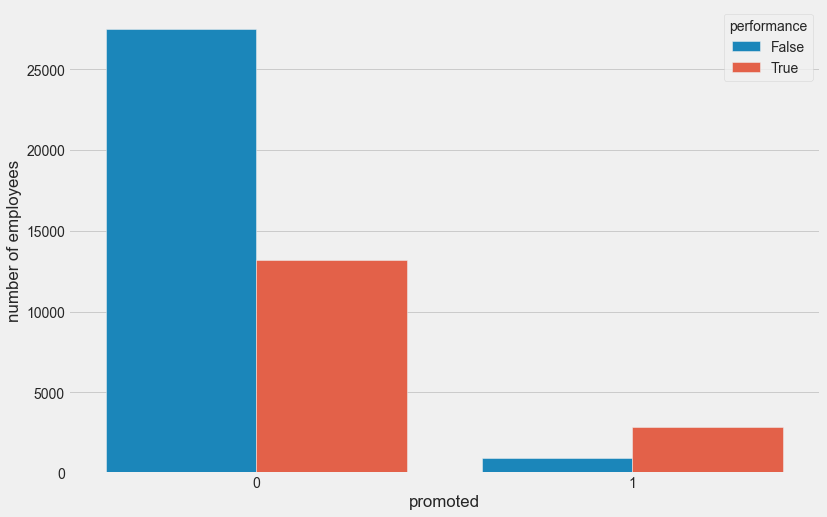

In [14]:
df['performance'] = df[['KPIs_met','awards_won']].any(axis=1,skipna=False)

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,8))
sns.countplot(df.is_promoted,hue=df.performance)
plt.xlabel('promoted')
plt.ylabel('number of employees')

The plot above compares counts of performance of employees who were promoted and performance of employees who were not promoted. The plot draws the following conclusions :-

* Out of the employees who were promoted, most of them had shown good performance.
* The employees who were not promoted have a high number of non-performing employees.

There exist a great number of employees who had performed but yet were not promoted. This could be due to various other reasons. This proves a compelling argument to analyze the other factors as well.

For the dataset under analysis, the number of male employees are more than double the female employees.

In [15]:
df.gender.value_counts(normalize=True)

m    0.702284
f    0.297716
Name: gender, dtype: float64

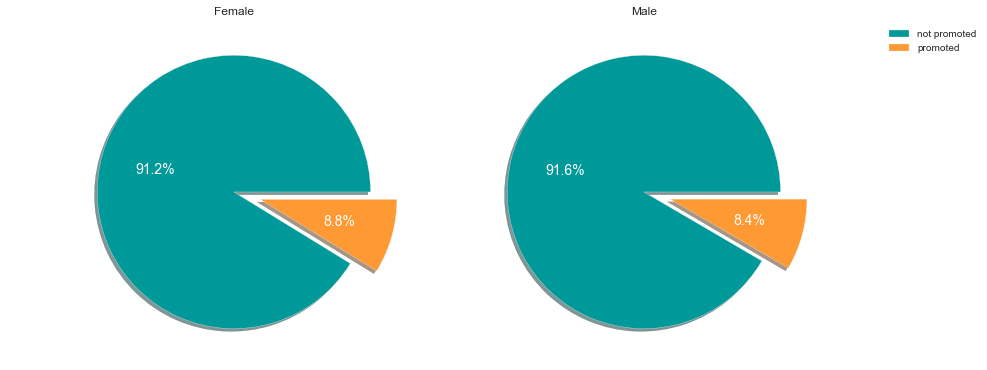

In [16]:
plt.style.use('seaborn')
plt.subplots(figsize=(12,8))
plt.subplot(1,2,1)
plt.pie(
    x=df[df.gender=='f'].is_promoted.value_counts(normalize=True),
    labels=['not promoted','promoted'],
    explode=[0,0.2],
    autopct="%1.1f%%",
    shadow=True,
    textprops=dict(color='w',fontsize=14),
    colors=['#009999','#ff9933']
)
plt.title("Female")
plt.subplot(1,2,2)
plt.pie(
    x=df[df.gender=='m'].is_promoted.value_counts(normalize=True),
    labels=['not promoted','promoted'],
    explode=[0,0.2],
    autopct="%1.1f%%",
    shadow=True,
    textprops=dict(color='w',fontsize=14),
    colors=['#009999','#ff9933']
)
plt.title("Male")
plt.legend(['not promoted','promoted'],loc='upper right', bbox_to_anchor=(1, 0.5, 0.5, 0.5))

The pie charts concludes that the two genders have equal proportions of promotions. This does not mean that equal number of females and males were promoted. the population of males is far greater than female. The proportions calculated are with respect to their population.<br>

The columns *no_of_trainings* and *avg_training_score* specify the number of company organized workshops and trainings has the employee attended and the average training score the employee recieved for the said trainings. Trainings and workshops are integral for an employee as they are hosted for skill development of the employees. These trainings scores help the company understand which employees are improving. The two columns individually do not provide a good assessment since they cannot be compared between employees.<br>

Say employee A scored an average training score of 60 but has attended only one workshop, and employee B achieves an average score of 50 but over 3 workshops. From the current perspective, employee A has a better score if the comparision is made on *avg_training_score*, but in reality, employee B has amassed a total of 150 training points whereas employee A has only 60.<br>
Another case, employee A has undergone only 1 training session and recieved an average training score of 100. Employee B underwent 3 training sessions and recieved an average training score of 25. By comparision on *no_of_trainings* employee A trumps employee B. In reality employee A has a total score of 100 whereas employee B has just 75. Number of trainings can be less for a recently joined employee as compared to a veteran in the company.<br>
The two above scenarios give rise to a third column - *total_score*, which gives an estimate of the total score recieved by an employee. This column is a good factor to compare and differentiate between employees who have shown improvement and those who havent.

In [17]:
df['total_score'] = df.no_of_trainings * df.avg_training_score
df.head(5)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met,awards_won,avg_training_score,is_promoted,performance,total_score
0,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,False,50
1,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,False,100
2,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,False,73
3,58896,Analytics,region_2,Bachelor's,m,sourcing,2,31,3.0,7,0,0,85,0,False,170
4,49017,Sales & Marketing,region_7,Bachelor's,f,sourcing,1,35,5.0,3,1,0,50,1,True,50


The *total_score* column is on the ratio scale i.e. is numeric. The aim is to compare the *total_score* with the *is_promoted* column to identify if any relationships exist. For the purpose the *total_score* column is divided into 3 bins (categories) :-

* Low - 65 or lower
* Mediocre - 65 to 145 points
* High - 145 or higher

The bins have been selected based on the distribution of the *total_score* column for the employees that were promoted. Using the `pd.cut()` functions the column is split into bins and stored in *total_score_label* column for further analysis.

In [18]:
df['total_score_label'] = pd.cut(df.total_score,bins=[0,65,145,1000],labels=['Low','Mediocre','High'])
df.head(5)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met,awards_won,avg_training_score,is_promoted,performance,total_score,total_score_label
0,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,False,50,Low
1,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,False,100,Mediocre
2,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,False,73,Mediocre
3,58896,Analytics,region_2,Bachelor's,m,sourcing,2,31,3.0,7,0,0,85,0,False,170,High
4,49017,Sales & Marketing,region_7,Bachelor's,f,sourcing,1,35,5.0,3,1,0,50,1,True,50,Low


In [19]:
scores = df.pivot_table(values='is_promoted',index='total_score_label')
scores

,is_promoted
total_score_label,
Low,0.056725
Mediocre,0.119173
High,0.098214


Text(0.5, 0, 'score level')

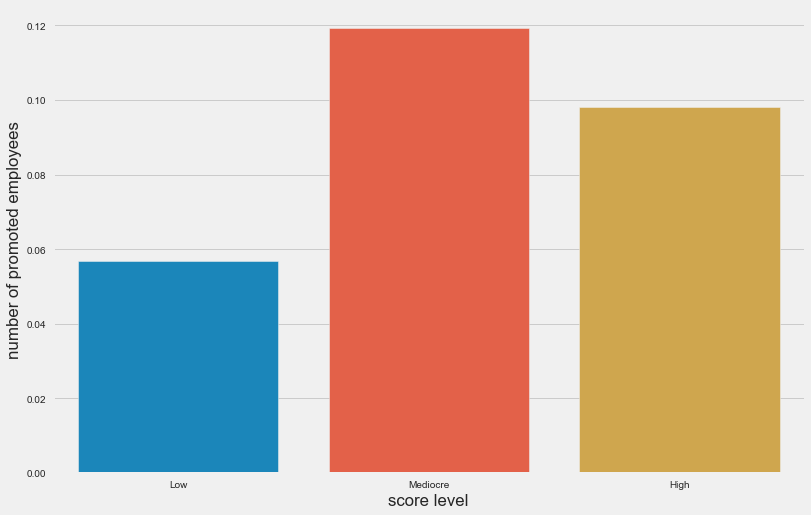

In [20]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,8))
sns.barplot(
    x=scores.index,
    y=scores.is_promoted
)
plt.ylabel('number of promoted employees')
plt.xlabel('score level')

The following conclusions can be drawn from the plot :-

* Employees promoted have scores in the Mediocre and High range i.e. 65 and greater 
* Employees with scores in the Low range have also been promoted a good percentage of times.
* Mediocre score level having the highest percentage of promoted employees means total score is not the only criterion for promotion.

A similar approach is taken for the *length_of_service* column. An employee who has been in a company longer is more likely to be promoted rather than a new joinee. Since the column is numeric, it is converted to categorical via binning into the following categories. 

* New - 0 to 2 years
* Established - 2 to 7 years
* Experienced - 7 to 10 years
* Veteran - 10 years or more

The categories have been chosen based on general trend. (Logic)

In [21]:
df['service_catg'] = pd.cut(
    df.length_of_service,
    bins=[0,2,7,10,37],
    labels=['New','Established','Experienced','Veteran']
)
df.head(5)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met,awards_won,avg_training_score,is_promoted,performance,total_score,total_score_label,service_catg
0,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,False,50,Low,Established
1,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,False,100,Mediocre,Experienced
2,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,False,73,Mediocre,New
3,58896,Analytics,region_2,Bachelor's,m,sourcing,2,31,3.0,7,0,0,85,0,False,170,High,Established
4,49017,Sales & Marketing,region_7,Bachelor's,f,sourcing,1,35,5.0,3,1,0,50,1,True,50,Low,Established


In [22]:
service = df.pivot_table(values='is_promoted',index='service_catg')
service

,is_promoted
service_catg,
New,0.085342
Established,0.084904
Experienced,0.092008
Veteran,0.077692


Text(0.5, 0, 'service category')

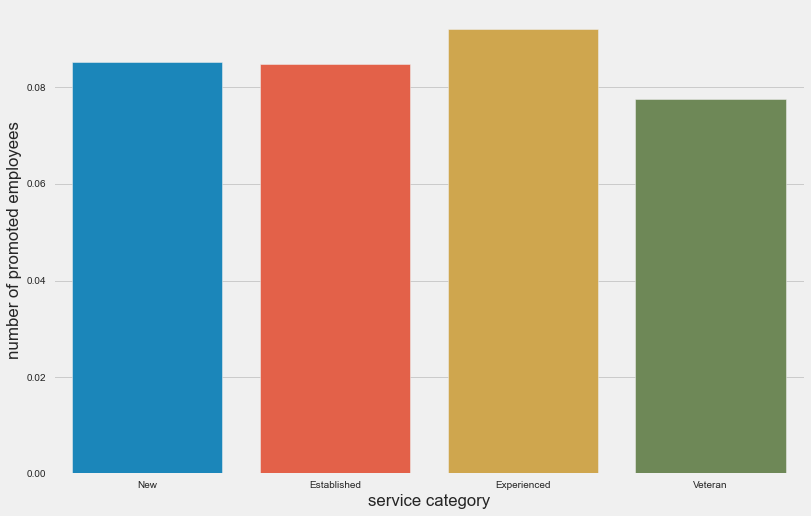

In [23]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,8))
sns.barplot(
    x=service.index,
    y=service.is_promoted
)
plt.ylabel('number of promoted employees')
plt.xlabel('service category')

The plot above concludes that :-

* Experienced employees are likely to get promoted than other categories, due to their experience and understanding of the company
* New and Established employees have almost equal likelihood of getting promoted.
* Veteran employees generally get less promotions. Due to their number of years given to the company, majority of them might have reached the pinnacle.

The *age* column is very similar to the service length, in terms that both define a temporal factor for the employee. The column is numeric. Assuming that an employee's career starts at the age of 20, and hence is binned into the following categories :-

* Young - Less than 25 years
* Middle - 25 to 40 years
* Senior - 40 to 50 years
* Elder - 50 years or older

On these categories, the percentage of people who were promoted from each category is calculated.

In [24]:
df['age_label'] = pd.cut(df.age,bins=[0,25,40,50,100],labels=['Young','Middle','Senior','Elder'])
df.head(5)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met,awards_won,avg_training_score,is_promoted,performance,total_score,total_score_label,service_catg,age_label
0,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,False,50,Low,Established,Middle
1,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,False,100,Mediocre,Experienced,Middle
2,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,False,73,Mediocre,New,Senior
3,58896,Analytics,region_2,Bachelor's,m,sourcing,2,31,3.0,7,0,0,85,0,False,170,High,Established,Middle
4,49017,Sales & Marketing,region_7,Bachelor's,f,sourcing,1,35,5.0,3,1,0,50,1,True,50,Low,Established,Middle


In [25]:
ages = df.pivot_table(values='is_promoted',index='age_label')
ages

,is_promoted
age_label,
Young,0.062602
Middle,0.090174
Senior,0.073596
Elder,0.069341


Text(0.5, 0, 'age category')

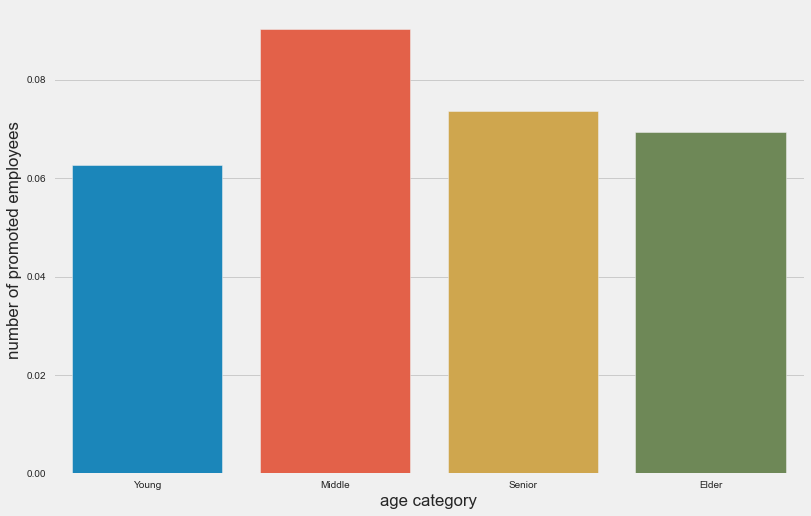

In [26]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,8))
sns.barplot(
    x=ages.index,
    y=ages.is_promoted
)
plt.ylabel('number of promoted employees')
plt.xlabel('age category')

The plot clearly states the following :-

* An employee aged between 25 and 40 years is likely to be promoted.
* A senior employee aged 40 to 50 years has a good chance of getting promoted.
* A Middle aged or Senior employee form the perfect age interval (25 to 50) where an employee is said to at the peak of his/her career.
* Younger or Elder employees have lesser chances of being promoted as the former has just begun their career and the latter is coming towards an end to their career.

The *service_catg* shows that a *New* employee is also likelier to get promoted. A *New* employee is not neccesarily a *Young* employee. Since *age_label* has been defined, this can be analyzed.

In [27]:
new_emps = df[df.service_catg == 'New']

new_age = new_emps.pivot_table(values='is_promoted',index='age_label')
new_age

,is_promoted
age_label,
Young,0.064242
Middle,0.092728
Senior,0.083969
Elder,0.000000


Text(0.5, 0, 'age category')

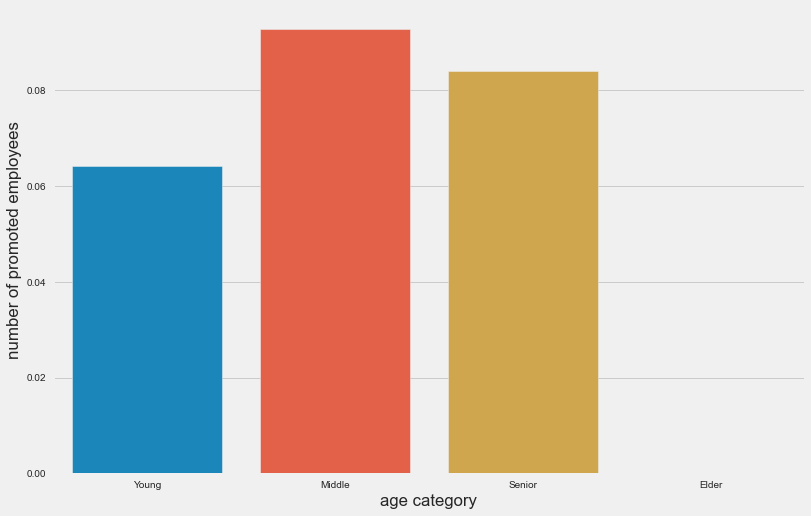

In [28]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,8))
sns.barplot(
    x=new_age.index,
    y=new_age.is_promoted
)
plt.ylabel('number of promoted employees')
plt.xlabel('age category')

The plot is conclusive of the facts :-

* No elder employees are new joinees, this is due to the fact that their end of career is nearing.
* Among the new joinees, the Middle aged and Senior employees are likelier to be promoted.
* The Young employees being promoted, means there must be a few other factors discussed above, that must be great for them.

The *previous_year_rating* describes the rating an employee recieved in the internal evaluations of the company in the previous year. These ratings give a clear differentiation between employees. By intuition, an employee with a good rating paired with other factors is likelier to be promoted. To prove this hypothesis, the *previous_year_rating* column is first encoded into labels for understanding. 

* New - rating 0, new employee
* Minimum - raitng 1
* Fair - rating 2
* Improving - rating 3
* Good - rating 4
* Very good - rating 5

NOTE: These rating labels are chosen to be subtle about it.

In [29]:
def decode(val):
    if val == 0:
        return 'New'
    elif val == 1:
        return 'Minimum'
    elif val == 2:
        return 'Fair'
    elif val == 3:
        return 'Improving'
    elif val == 4:
        return 'Good'
    else:
        return 'Very good'
    
df['rating_label'] = df.previous_year_rating.apply(decode)
df.head(5)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met,awards_won,avg_training_score,is_promoted,performance,total_score,total_score_label,service_catg,age_label,rating_label
0,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,False,50,Low,Established,Middle,Improving
1,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,False,100,Mediocre,Experienced,Middle,Minimum
2,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,False,73,Mediocre,New,Senior,Improving
3,58896,Analytics,region_2,Bachelor's,m,sourcing,2,31,3.0,7,0,0,85,0,False,170,High,Established,Middle,Improving
4,49017,Sales & Marketing,region_7,Bachelor's,f,sourcing,1,35,5.0,3,1,0,50,1,True,50,Low,Established,Middle,Very good


In [30]:
ratings = df.pivot_table(values='is_promoted',index='rating_label')
ratings

,is_promoted
rating_label,
Fair,0.043212
Good,0.080334
Improving,0.072513
Minimum,0.014476
New,0.080487
Very good,0.162851


Text(0.5, 0, 'ratings')

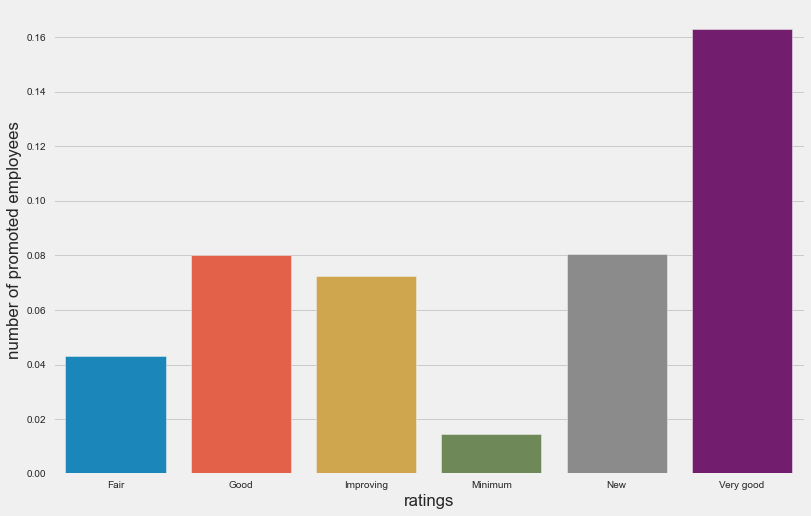

In [31]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,8))
sns.barplot(
    x=ratings.index,
    y=ratings.is_promoted
)
plt.ylabel('number of promoted employees')
plt.xlabel('ratings')

The plot proves the hypothesis coined earlier.

* Employees with 'Very good' rating (5) are most likely to be promoted.
* The trend in the number of people promoted is upwards from 'Minimum' to 'Very good' rating. 
* 'New' (no previous year rating) employees shows good percentage of people being promoted. For these employees, other factors are dominant.

The last columns to analyze are the *department* and *education*. Intuitively the education of an employee is very important when recruiting, but once the employee has joined, the performance within the company is what should matter. Promotions happen within each departments, meaning a sales employee is promoted but stays in the sales department. This can be considered to generally true, with ofcourse a few exceptions. By these arguments, the two columns offer less inuition when analyzing which factors affect an employee's promotion.

In [32]:
rm_cols = [
    'employee_id',
    'department',
    'region',
    'education',
    'gender',
    'recruitment_channel',
    'KPIs_met',
    'awards_won',
    'total_score_label',
    'service_catg',
    'age_label',
    'rating_label'
]

df.drop(rm_cols,axis=1,inplace=True)
df.head(5)

,no_of_trainings,age,previous_year_rating,length_of_service,avg_training_score,is_promoted,performance,total_score
0,1,34,3.0,7,50,0,False,50
1,2,39,1.0,10,50,0,False,100
2,1,45,3.0,2,73,0,False,73
3,2,31,3.0,7,85,0,False,170
4,1,35,5.0,3,50,1,True,50


The dataframe above is the final dataset with the factors that affect promotion. This will be now used for model building. <br>
The performance column has to be converted to numeric bool.

In [33]:
df.performance = df.performance.apply(lambda x: 1 if x else 0)

The dataset is scaled using the `MinMaxScaler` from the `sklearn.preprocessing` module. This way all columns are on the same scale. Before model building, the scaled dataset is split into Training set and Testing set with 80:20 ratio.

0    40701
1     3791
Name: is_promoted, dtype: int64


C:\Users\Manoj\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_promoted', ylabel='count'>

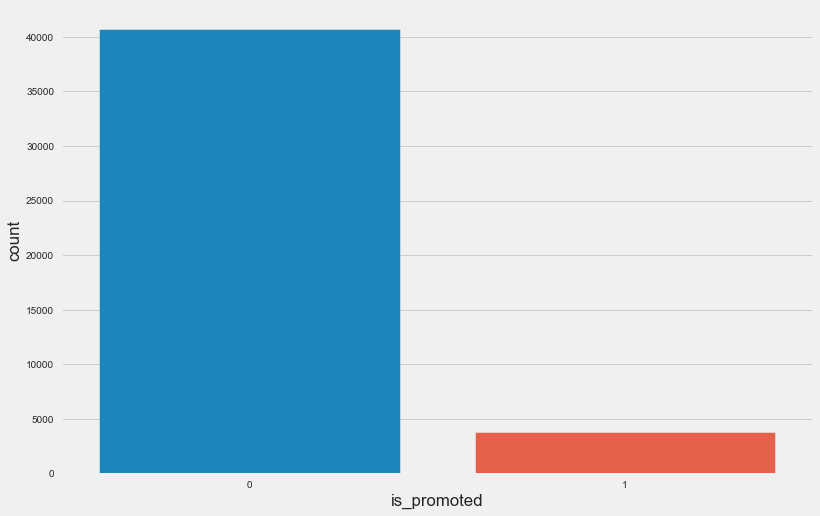

In [34]:
print(df.is_promoted.value_counts())

plt.figure(figsize=(12,8))
sns.countplot(df.is_promoted)

The dataset has a huge imbalance in the target classes. Training a classifier on imbalanced classes can prove problems in precision and recall of the model. Depending on which class is lesser than the other :-

* low recall + high precision : the model can’t detect the class well but is highly trustable when it does. 
* high recall + low precision : the class is well detected but the model also include points of other classes in it

To overcome this problem, two solutions are suggested. Either the dataset is undersampled to match the classes or the dataset is oversampled and the class with lesser representatives is increased. Undersampling can cause loss of data and in this case since class 1 has only 4668 data points, the total depth of the data would be reduced to around 9000. Effectively the model would lose 41000 data points. Oversampling seems like the better option. The function `RandomOverSampler` from `imblearn.over_sampling` module is used.

In [35]:
X = df.drop('is_promoted',axis=1)
y = df.is_promoted

cols = X.columns

resampler = RandomOverSampler(random_state=1)
X_res,y_res = resampler.fit_resample(X,y)
print(X_res.shape)
print(y_res.value_counts())

(81402, 7)
0    40701
1    40701
Name: is_promoted, dtype: int64


In [36]:
scaler = MinMaxScaler()
X_res = pd.DataFrame(scaler.fit_transform(X_res))
X_res.head(5)

,0,1,2,3,4,5,6
0,0.000000,0.350,0.6,0.181818,0.183333,0.0,0.016393
1,0.111111,0.475,0.2,0.272727,0.183333,0.0,0.090909
2,0.000000,0.625,0.6,0.030303,0.566667,0.0,0.050671
3,0.111111,0.275,0.6,0.181818,0.766667,0.0,0.195231
4,0.000000,0.375,1.0,0.060606,0.183333,1.0,0.016393


In [37]:
X_train,X_test,y_train,y_test = train_test_split(X_res,y_res,random_state=0)

Using the `sklearn.model_selection` - `cross_validate` function, the entire dataset will be cross-validated on the entire dataset to see how the model performs on this dataset. The cross validation gives a good method for model selection. The model which performs good on cross validation is then chosen for further training, testing and hyper-parameter tuning.<br>
The ML model chosen here is `GradientBoostingClassifier`. This model is a good classification model and removes any bias in the data. It is robust to over fitting. Since it uses ensemble techniques, various trees are used as predictors. One tree can develop bias, but the combination of outputs of many trees give a stable result.

In [38]:
scores = cross_validate(
    GradientBoostingClassifier(max_depth=10,random_state=0),
    X_res,
    y_res,
    cv=5,
    scoring=['accuracy','precision_macro','recall_macro','f1'],
    verbose=2
)
print('Avg Test score: ',np.mean(scores['test_accuracy']))
print('Avg Precision: ',np.mean(scores['test_precision_macro']))
print('Avg Recall: ',np.mean(scores['test_recall_macro']))
print('Avg F1 score: ',np.mean(scores['test_f1']))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  54.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.2s remaining:    0.0s


[CV] END .................................................... total time=  53.8s
[CV] END .................................................... total time=  52.9s
[CV] END .................................................... total time=  54.2s
[CV] END .................................................... total time=  53.4s
Avg Test score:  0.8865875516704703
Avg Precision:  0.8972827035777788
Avg Recall:  0.8865873968238542
Avg F1 score:  0.8951758370016583


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.5min finished


Cross-validation on the resampled dataset shows excellent results. The average Test set accuracy is about 87% with precision and recall around the same neighbourhood. f1 scores give a holistic view of the precision and recall, which is very good in this case, about 88%.
Thus it can be concluded that the `GradientBoostingClassifier` is a good predictor for this dataset.<br>
The next step is hyper-parameter tuning. This tunes the parameters of the model to the best set that can maximize the accuracy of the model. Letting the learning rate be fixed at 0.1, the max_depth of the trees (estimators) will be varied between 10 and 25 to get the optimal value. For this parameter a `validation curve` is made. The validation curve is a plot of the train and test accuracies vs a parameter under optimization.

In [39]:
params = np.arange(10,26,1)
scores = validation_curve(
    GradientBoostingClassifier(),
    X_res,
    y_res,
    param_name='max_depth',
    param_range=params,
    scoring='accuracy',
    verbose=3,
    cv=2,
    n_jobs=-1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  32 | elapsed:  5.7min remaining: 10.9min
[Parallel(n_jobs=-1)]: Done  22 out of  32 | elapsed:  8.5min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed: 11.9min finished


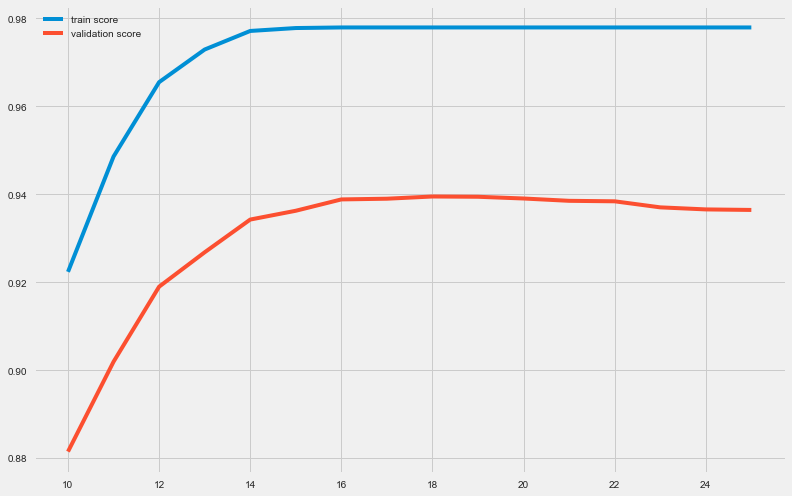

In [40]:
train_scores = scores[0]
test_scores = scores[1]

train_means = np.mean(train_scores,axis=1)
test_means = np.mean(test_scores,axis=1)

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,8))
sns.lineplot(x=params,y=train_means)
sns.lineplot(x=params,y=test_means)
plt.legend(['train score','validation score'])

The validation curve for the test accuracy identifies the optimal value of max_depth for classifier. In this case the max_depth value of 20 yields a average test accuracy of 94%. This accuracy is quite good and shows that the model has learnt the classes well and is highly trustable in its predictions.<br>
The validation curve is intuitive when plotting for a single parameter. The `GradientBoostingClassifier` has many parameters such as `learning_rate`, `max_depth`, `n_estimators` etc. When the best value for these have to be found together, `GridSearchCV` is used. For every combination of these parameters cross validation is performed. The combination giving the best score is returned along with the parameters in the combination.

In [41]:
model = GradientBoostingClassifier(max_depth=20,random_state=0)
grid_vals ={
    'learning_rate':np.arange(0.1,0.5,0.1),
    'n_estimators':np.arange(100,500,100)
}
grid_mod = GridSearchCV(model,param_grid=grid_vals,cv=2,verbose=1,n_jobs=-1)
grid_mod.fit(X_train,y_train)
print(grid_mod.best_params_)
print(grid_mod.best_score_)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
{'learning_rate': 0.4, 'n_estimators': 300}
0.9284368476211495


After performing a `Grid search` the optimal paramters for the model are returned. Using these parameters, the model is finally trained on the train set and tested as well as make predictions on the test set. This model becomes the final output from the analysis.

In [42]:
#Applying Gradient Boosting Classifier
model = GradientBoostingClassifier(learning_rate=0.4,n_estimators=300,max_depth=20,random_state=0)
model.fit(X_train,y_train)
print(model.score(X_train,y_train))
print(model.score(X_test,y_test))

0.9773468084060867
0.9604933418505233


The above model does extremely well due to the hyper-paramter tuning executed on the model. The model gives the best fit possible with a test set accuracy of 96%. Generating a `classification_report` to gain more insights into the model.

In [43]:
pred = model.predict(X_test)
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      9355
           1       1.00      0.93      0.96     10996

    accuracy                           0.96     20351
   macro avg       0.96      0.96      0.96     20351
weighted avg       0.96      0.96      0.96     20351



# Prediction of the unseen data

In [94]:
unseen_data=pd.read_csv('hr problem data - test.csv')

In [95]:
unseen_data.isnull().sum()

employee_id               0
department                0
region                    0
education               451
gender                    0
recruitment_channel       0
no_of_trainings           0
age                       0
previous_year_rating    757
length_of_service         0
KPIs_met >80%             0
awards_won?               0
avg_training_score        0
is_promoted               0
random                    0
group                     0
dtype: int64

In [96]:
unseen_data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,random,group
0,20379,Operations,region_20,Bachelor's,f,other,1,31,3.0,5,0,0,59,0,0,0
1,38401,Technology,region_29,Master's & above,m,other,2,39,3.0,16,0,0,80,0,0,0
2,9403,Sales & Marketing,region_31,Bachelor's,m,other,1,34,1.0,4,0,0,51,0,1,0
3,25014,Technology,region_15,Bachelor's,m,other,1,34,3.0,10,0,0,80,0,0,0
4,45709,Sales & Marketing,region_31,Bachelor's,f,other,1,29,NaN,1,0,0,49,0,2,0


# Applying feature engineering and preprocessing on the unseen data which we applied on the training data

In [97]:
unseen_data.previous_year_rating=unseen_data.previous_year_rating.fillna(0)
unseen_data['total_score'] = unseen_data.no_of_trainings * unseen_data.avg_training_score
unseen_data.rename(columns={'KPIs_met >80%':'KPIs_met','awards_won?':'awards_won'},inplace=True)
unseen_data['performance'] = unseen_data[['KPIs_met','awards_won']].any(axis=1,skipna=False)

In [98]:
rm_cols = [
    'employee_id',
    'department',
    'region',
    'education',
    'gender',
    'recruitment_channel',
    'KPIs_met',
    'awards_won',
     'random',
    'group',
    'is_promoted'
]

unseen_data.drop(rm_cols,axis=1,inplace=True)
unseen_data.head(5)

,no_of_trainings,age,previous_year_rating,length_of_service,avg_training_score,total_score,performance
0,1,31,3.0,5,59,59,False
1,2,39,3.0,16,80,160,False
2,1,34,1.0,4,51,51,False
3,1,34,3.0,10,80,80,False
4,1,29,0.0,1,49,49,False


In [99]:
scaler = MinMaxScaler()
X_res = pd.DataFrame(scaler.fit_transform(X_res))
X_res.head(5)

,0,1,2,3,4,5,6
0,0.000000,0.350,0.6,0.181818,0.183333,0.0,0.016393
1,0.111111,0.475,0.2,0.272727,0.183333,0.0,0.090909
2,0.000000,0.625,0.6,0.030303,0.566667,0.0,0.050671
3,0.111111,0.275,0.6,0.181818,0.766667,0.0,0.195231
4,0.000000,0.375,1.0,0.060606,0.183333,1.0,0.016393


In [104]:
prediction_data=model.predict(X_res)

In [105]:
print(list(prediction_data))

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 